<a href="https://colab.research.google.com/github/Aburoobha/FUNDUS-image-classification/blob/main/FUNDUS_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download linchundan/fundusimage1000 -p "/content/sample_data"
!unzip "/content/sample_data/fundusimage1000.zip" -d "/content/sample_data"
!rm -rf "/content/sample_data/fundusimage1000.zip"
!rm -rf "/content/sample_data/1000images/1000images"

Dataset URL: https://www.kaggle.com/datasets/linchundan/fundusimage1000
License(s): DbCL-1.0
 98% 761M/778M [00:09<00:00, 62.3MB/s]
100% 778M/778M [00:09<00:00, 89.8MB/s]
Archive:  /content/sample_data/fundusimage1000.zip
  inflating: /content/sample_data/1000images/0.0.Normal/1ffa9627-8d87-11e8-9daf-6045cb817f5b..JPG  
  inflating: /content/sample_data/1000images/0.0.Normal/1ffa9628-8d87-11e8-9daf-6045cb817f5b..JPG  
  inflating: /content/sample_data/1000images/0.0.Normal/1ffa9629-8d87-11e8-9daf-6045cb817f5b..JPG  
  inflating: /content/sample_data/1000images/0.0.Normal/1ffa962a-8d87-11e8-9daf-6045cb817f5b..JPG  
  inflating: /content/sample_data/1000images/0.0.Normal/1ffa962b-8d87-11e8-9daf-6045cb817f5b..JPG  
  inflating: /content/sample_data/1000images/0.0.Normal/1ffa962d-8d87-11e8-9daf-6045cb817f5b..JPG  
  inflating: /content/sample_data/1000images/0.0.Normal/1ffa962e-8d87-11e8-9daf-6045cb817f5b..JPG  
  inflating: /content/sample_data/1000images/0.0.Normal/1ffa962f-8d87-11e8-9da

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.applications import VGG16
from keras.regularizers import l2


In [ ]:
batch_size = 32
epochs = 100

In [ ]:
# Load images and labels into numpy arrays
def load_images_and_labels(dataset_dir, img_size=(128, 128)):
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_dir))
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(dataset_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is None: # Check if image loaded successfully
                print(f"Failed to load image: {img_path}")
                continue # Skip to next image if loading failed
            img = cv2.resize(img, img_size)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append(img)
            labels.append(class_indices[class_name])

    images = np.array(images)
    # images = np.expand_dims(images, axis=-1)
    labels = np.array(labels)
    return images, labels, class_indices

dataset_dir = '/content/sample_data/1000images'
img_size = (128, 128)
images, labels, class_indices = load_images_and_labels(dataset_dir, img_size)

In [ ]:
# Normalize images
images = images / 255.0

# One-hot encode labels
num_classes = len(class_indices)
labels = to_categorical(labels, num_classes)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Create an ImageDataGenerator object for augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the datagen on the training data
datagen.fit(X_train)

# Load the VGG16 model
input_shape = (128, 128, 3)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze the last few layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
print(X_train.shape, "\n", y_train.shape)

(700, 128, 128, 3) 
 (700, 39)


In [ ]:
my_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('my_model_multiclass.h5',
    verbose=1, save_best_only=True, save_weights_only=False)
]
# Model Training
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    callbacks = my_callbacks)

model.save('my_model_multiclass.h5')

Epoch 1/200
21/21 [==============================] - ETA: 0s - loss: 3.9535 - accuracy: 0.0599
Epoch 1: val_loss improved from inf to 3.74249, saving model to my_model_multiclass.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 11s 251ms/step - loss: 3.9535 - accuracy: 0.0599 - val_loss: 3.7425 - val_accuracy: 0.1300 - lr: 1.0000e-04
Epoch 2/200
21/21 [==============================] - ETA: 0s - loss: 3.6902 - accuracy: 0.1452
Epoch 2: val_loss improved from 3.74249 to 3.51997, saving model to my_model_multiclass.h5
21/21 [==============================] - 6s 267ms/step - loss: 3.6902 - accuracy: 0.1452 - val_loss: 3.5200 - val_accuracy: 0.1867 - lr: 1.0000e-04
Epoch 3/200
21/21 [==============================] - ETA: 0s - loss: 3.4995 - accuracy: 0.1692
Epoch 3: val_loss improved from 3.51997 to 3.42958, saving model to my_model_multiclass.h5
21/21 [==============================] - 5s 220ms/step - loss: 3.4995 - accuracy: 0.1692 - val_loss: 3.4296 - val_accuracy: 0.2133 - lr: 1.0000e-04
Epoch 4/200
21/21 [==============================] - ETA: 0s - loss: 3.3674 - accuracy: 0.2024
Epoch 4: val_loss improved from 3.42958 to 3.29023, saving model to my_model_multiclass.

In [ ]:
# Model Evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.2f}')

10/10 [==============================] - 0s 45ms/step - loss: 1.8817 - accuracy: 0.7167
Test accuracy: 0.72


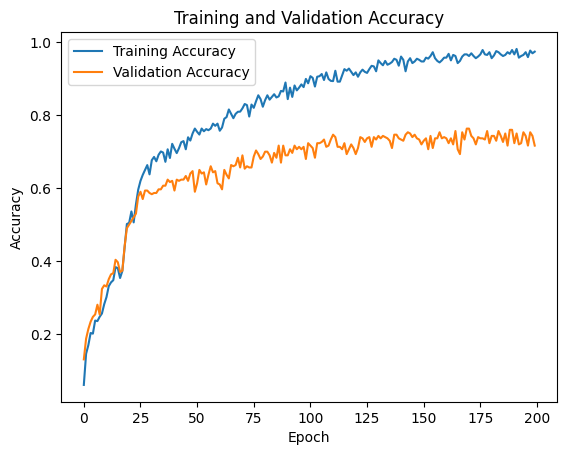

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

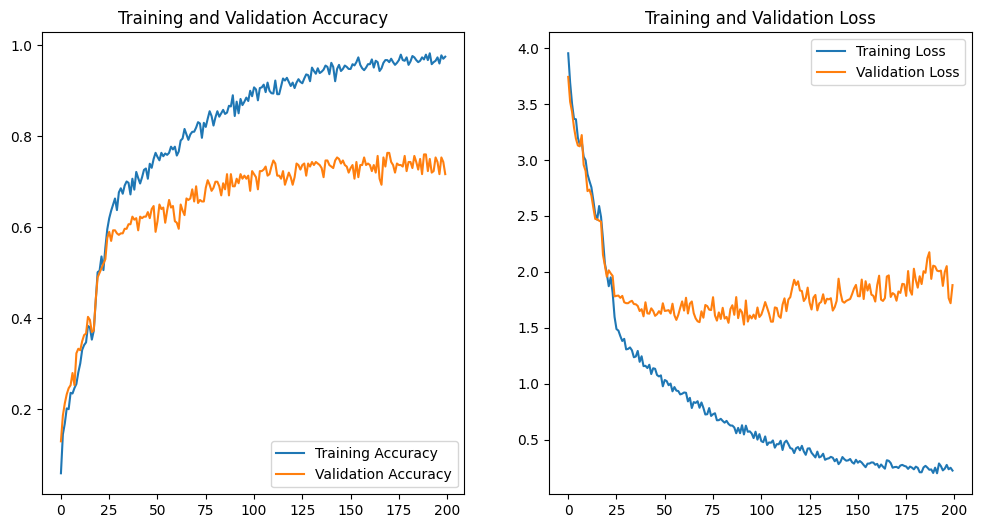

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# Predict the labels for the test set
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = np.argmax(y_test, axis=1)

# Get the class indices
class_labels = list(class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_labels, labels=range(num_classes)))

# Print confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
print(cm)

10/10 [==============================] - 1s 38ms/step
                                              precision    recall  f1-score   support

                                  0.0.Normal       0.67      0.83      0.74        12
                      0.1.Tessellated fundus       0.40      0.67      0.50         3
                         0.2.Large optic cup       0.89      0.80      0.84        20
                                     0.3.DR1       0.62      1.00      0.77         5
                                     1.0.DR2       0.40      0.75      0.52         8
                                     1.1.DR3       0.40      0.25      0.31         8
                      10.0.Possible glaucoma       0.00      0.00      0.00         7
                          10.1.Optic atrophy       0.50      0.67      0.57         3
          11.Severe hypertensive retinopathy       0.33      0.50      0.40         4
              12.Disc swelling and elevation       0.67      0.33      0.44         6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
